In [1]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import gc
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
import multiprocessing as mp

os.chdir('../..')
os.getcwd()

'/home/vschuste/projects/interpreting_omics_models'

### Load data and models

In [2]:
# load model and data

dev_id = 3
device = torch.device(f"cuda:{dev_id}" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {device}")
    data_dir = '/home/vschuste/data/singlecell/'
else:
    data_dir = '/Users/vschuste/Documents/work/data/singlecell/'

data = ad.read_h5ad(data_dir+'human_bonemarrow.h5ad')

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e').to(device)
data = data[data.obs["train_val_test"] == "train"]
library = data.obs['GEX_n_counts'].values
data_gene_names = (data.var[data.var['modality'] == 'GEX']).index
data_gene_ids = data.var[data.var['modality'] == 'GEX']['gene_id'].values
del data
gc.collect()
# get the model's dispersions for the DEG test
with torch.no_grad():
    dispersion_factors = (torch.exp(model.decoder.out_modules[0].distribution.log_r).detach().cpu().numpy() + 1).flatten()

reps = model.representation.z.detach()

Using GPU: cuda:3
Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        


/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/multiDGD/_dgd.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self._sa

#######################
Training status
#######################
True


## Functions

In [7]:
import torch.nn as nn

class SparseAutoencoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            #nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [11]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

def run_nb_model(y_pos, y_neg, gene_idx, conditions, pairing):
    # Combine the gene expression data for the current gene across both conditions
    gene_expression = np.concatenate([y_pos[:, gene_idx], y_neg[:, gene_idx]])

    # Design matrix: Intercept (ones), pairing, and condition
    X = np.column_stack([np.ones_like(conditions), pairing, conditions])

    # Fit a negative binomial model for the current gene
    glm_model = sm.GLM(gene_expression, X, family=NegativeBinomial(alpha=dispersion_factors[gene_idx]))
    result = glm_model.fit()

    # Extract p-value for the condition (perturbation effect)
    p_value = result.pvalues[2]  # The p-value for the "condition" variable
    fold_change = np.exp(result.params[2])  # Fold change is exp(beta)

    return p_value, fold_change

def DEG_analysis_paired(y_pos, y_neg, gene_names):

    fold_changes = y_pos.mean(axis=0) / y_neg.mean(axis=0)

    n_cells, n_genes = y_pos.shape

    # Prepare condition and pairing information
    # Condition: 0 for HSC, 1 for perturbation
    conditions = np.array([0] * n_cells + [1] * n_cells)

    # Pairing: Each pair corresponds to the same cell in HSC and perturbation
    pairing = np.tile(np.arange(n_cells), 2)

    # do this faster with multiprocessing
    pool = mp.Pool(mp.cpu_count())
    p_values, fold_changes = zip(*pool.starmap(run_nb_model, [(y_pos, y_neg, gene_idx, conditions, pairing) for gene_idx in range(n_genes)]))

    # Convert p-values and fold changes into a DataFrame
    gene_p_values = pd.DataFrame({
        'gene': gene_names,  # Assuming you have gene names as your columns' index
        'p_value': p_values,
        'fold_change': fold_changes
    })

    # Adjust p-values for multiple testing using Benjamini-Hochberg correction
    gene_p_values['adj_p_value'] = multipletests(gene_p_values['p_value'], method='fdr_bh')[1]

    # Sort the results by p-value
    gene_p_values = gene_p_values.sort_values(by='p_value')

    # Print the top differentially expressed genes
    print(gene_p_values.head())

    return gene_p_values

def DEG_analysis_unpaired(y_pos, y_neg, gene_names):

    fold_changes = y_pos.mean(axis=0) / y_neg.mean(axis=0)

    # Perform unpaired t-tests for each gene
    p_values = []
    for gene in range(y_pos.shape[1]):
        t_stat, p_val = stats.ttest_ind(y_pos[:,gene], y_neg[:,gene], equal_var=False)  # Unequal variance (Welch's t-test)
        p_values.append(p_val)

    # Convert the p-values into a numpy array for further processing
    p_values = np.array(p_values)

    # Convert p-values and fold changes into a DataFrame
    gene_p_values = pd.DataFrame({
        'gene': gene_names,  # Assuming you have gene names as your columns' index
        'p_value': p_values,
        'fold_change': fold_changes
    })

    # Adjust p-values for multiple testing using Benjamini-Hochberg correction
    gene_p_values['adj_p_value'] = multipletests(gene_p_values['p_value'], method='fdr_bh')[1]

    # Sort the results by p-value
    gene_p_values = gene_p_values.sort_values(by='p_value')

    # Print the top differentially expressed genes
    print(gene_p_values.head())

    return gene_p_values

def get_top_genes_from_DEG(gene_p_values, fold_change_threshold=[0.5,2.0], p_value_threshold=0.05, plotting=True):
    top_genes = gene_p_values[((gene_p_values['fold_change'] < fold_change_threshold[0]) | (gene_p_values['fold_change'] > fold_change_threshold[1])) & (gene_p_values['adj_p_value'] < p_value_threshold)]['gene']
    
    if plotting:
        # plot fold change against adjusted p value
        plt.figure(figsize=(6, 3))
        sns.scatterplot(data=gene_p_values, x='fold_change', y='adj_p_value', alpha=0.7, s=5, ec=None)
        plt.xlabel('Fold Change')
        plt.ylabel('Adjusted p-value')
        plt.title('Differential Gene Expression')
        top_genes_indices = np.where(gene_p_values['gene'].isin(top_genes))[0]
        # remove the white around the points
        sns.scatterplot(data=gene_p_values.iloc[top_genes_indices], x='fold_change', y='adj_p_value', color='red', alpha=0.7, s=5, ec=None)
        plt.legend().remove()
        plt.show()
    
    return top_genes

# GEX

## Get SAE activation and predicted outputs

In [5]:
# load the SAE model and activations

sae_model_save_name = '03_results/models/sae_model_10000_l1-1e-3_lr-1e-4_500epochs'

input_size = reps.shape[1]
hidden_size = 10**4
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt'))
sae_model.to(device)

activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

In [6]:
active_feature_ids = torch.where(activations.sum(dim=0) > 0)[0]
print(len(active_feature_ids))

5318


In [7]:
activations.shape

torch.Size([56714, 10000])

## create sample sets per SAE feature

Investigating feature  2306


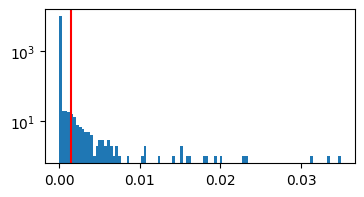

There are 100 samples in the top 99% of the feature


In [8]:
feat = 2306
#style = "paired"
style = "unpaired"
print("Investigating feature ", feat)

# get the sample IDs of the top 5% of the values of the feature
percentile = 99
top5pct = np.percentile(activations[feat].numpy(), percentile)
fig, ax = plt.subplots(figsize=(4, 2))
plt.hist(activations[feat].numpy(), bins=100)
plt.yscale('log')
plt.axvline(top5pct, color='red')
plt.show()
top5pct_indices = torch.where(activations[feat] > top5pct)[0]
print(f"There are {len(top5pct_indices)} samples in the top {percentile}% of the feature")

Investigating feature  100


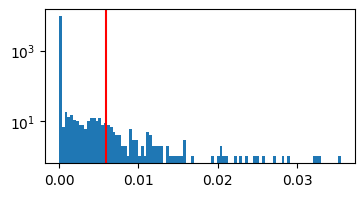

There are 100 samples in the top 99% of the feature


In [11]:
feat = 100
#style = "paired"
style = "unpaired"
print("Investigating feature ", feat)

# get the sample IDs of the top 5% of the values of the feature
percentile = 99
top5pct = np.percentile(activations[feat].numpy(), percentile)
fig, ax = plt.subplots(figsize=(4, 2))
plt.hist(activations[feat].numpy(), bins=100)
plt.yscale('log')
plt.axvline(top5pct, color='red')
plt.show()
top5pct_indices = torch.where(activations[feat] > top5pct)[0]
print(f"There are {len(top5pct_indices)} samples in the top {percentile}% of the feature")

Investigating feature  2306


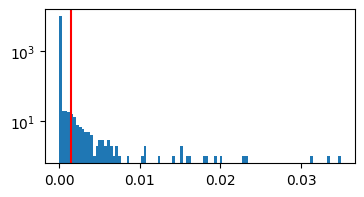

There are 100 samples in the top 99% of the feature
There are 9823 samples in the bottom of the feature (value 0)


In [7]:
#i = 0
#feat = active_feature_ids[i].item()
feat = 2306
#style = "paired"
style = "unpaired"
print("Investigating feature ", feat)

# get the sample IDs of the top 5% of the values of the feature
percentile = 99
top5pct = np.percentile(activations[feat].numpy(), percentile)
fig, ax = plt.subplots(figsize=(4, 2))
plt.hist(activations[feat].numpy(), bins=100)
plt.yscale('log')
plt.axvline(top5pct, color='red')
plt.show()
top5pct_indices = torch.where(activations[feat] > top5pct)[0]
print(f"There are {len(top5pct_indices)} samples in the top {percentile}% of the feature")

# get the reps
reps_top5pct = reps[top5pct_indices, :].clone()
cov_reps_top5pct = model.correction_rep.z[top5pct_indices, :].clone()

# get the positive predictions
y_pos = model.decoder(torch.cat((reps_top5pct, cov_reps_top5pct), dim=1))[0].detach().cpu().numpy()
y_pos = y_pos * library[top5pct_indices].reshape(-1, 1)

if style == "paired":
    # create the negative set by setting the activation of feat to zero
    activs_neg = activations[top5pct_indices, :].clone()
    activs_neg[:, feat] = 0
    reps_neg = sae_model.decoder(activs_neg.to(device)).detach()

    # now get the model predictions
    y_neg = model.decoder(torch.cat((reps_neg, cov_reps_top5pct), dim=1))[0].detach().cpu().numpy()
    y_neg = y_neg * library[top5pct_indices].reshape(-1, 1)
else:
    bottom_indices = torch.where(activations[feat] == 0.0)[0]
    print(f"There are {len(bottom_indices)} samples in the bottom of the feature (value 0)")
    reps_bottom = reps[bottom_indices, :].clone()
    cov_reps_bottom = model.correction_rep.z[bottom_indices, :].clone()

    # now get the model predictions
    y_neg = model.decoder(torch.cat((reps_bottom, cov_reps_bottom), dim=1))[0].detach().cpu().numpy()
    y_neg = y_neg * library[bottom_indices].reshape(-1, 1)

## differential expression analysis over different thresholds

In [34]:
gene_p_values = DEG_analysis_paired(y_pos, y_neg, data_gene_names)

       gene   p_value  fold_change  adj_p_value
9672   HBA2  0.148757     0.799837     0.999999
9671    HBM  0.166066     0.764002     0.999999
5801    CA1  0.177893     0.748631     0.999999
7161   SOX6  0.181433     0.700629     0.999999
929   SPTA1  0.194256     0.681705     0.999999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


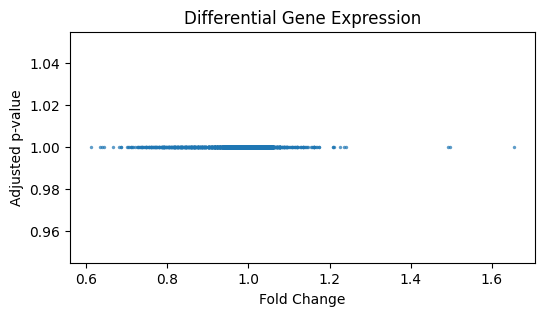

0


In [35]:
fold_change_threshold = [0.2, 5.0]
p_value_threshold = 1e-5

top_genes = get_top_genes_from_DEG(gene_p_values, fold_change_threshold, p_value_threshold)

print(len(top_genes))

In [8]:
gene_p_values = DEG_analysis_unpaired(y_pos, y_neg, data_gene_names)

          gene       p_value  fold_change   adj_p_value
4237   TMEM14C  3.168602e-24     0.426123  4.255749e-20
10980      TK1  4.404352e-23     0.339123  2.957742e-19
887       PKLR  5.170622e-22     0.255141  2.314887e-18
9742     TEDC2  7.431749e-22     0.451857  2.495396e-18
9680      NME4  7.798547e-19     0.411449  2.094846e-15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


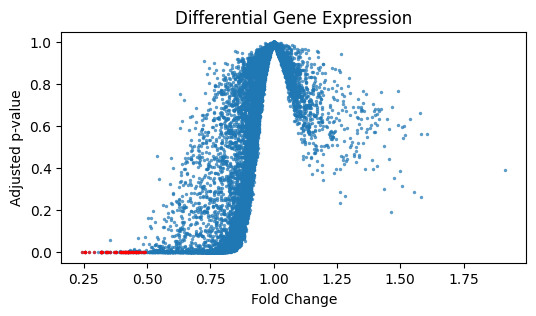

56


In [9]:
fold_change_threshold = [0.5, 2.0]
p_value_threshold = 1e-5

top_genes = get_top_genes_from_DEG(gene_p_values, fold_change_threshold, p_value_threshold)

print(len(top_genes))

In [46]:
# export the top genes for a test
top_genes.to_csv('03_results/reports/top_genes_test.csv', index=False)

In [10]:
# now we can delete the model and the data
del model
del sae_model
del activations
del reps
torch.cuda.empty_cache()
gc.collect()

2220

## GO term enrichment analysis for gene sets

### First define a reasonable set of GO terms

In [7]:
# get go term reference: term, description, level
if not os.path.exists('01_data/go-basic.obo'):
    os.chdir('01_data')
    !wget https://purl.obolibrary.org/obo/go/go-basic.obo -O go-basic.obo
    !pip install goatools
    os.chdir('..')
from goatools.obo_parser import GODag
obodag = GODag("01_data/go-basic.obo")

# reference: proteins and associated GO terms
if not os.path.exists('01_data/goa_human.gaf'):
    os.chdir('01_data')
    !wget https://current.geneontology.org/annotations/goa_human.gaf.gz -O goa_human.gaf.gz
    !gunzip goa_human.gaf.gz
    !rm goa_human.gaf.gz
    os.chdir('..')
from goatools.anno.gaf_reader import GafReader

ogaf = GafReader("01_data/goa_human.gaf")
ns2assc = ogaf.get_ns2assc()

# I need protein name to ensemble conversion
if not os.path.exists('01_data/protname2ensembl.tsv'):
    os.chdir('01_data')
    if not os.path.exists('idmapping_selected.tab'):
        !wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/idmapping_selected.tab.gz
        !gunzip idmapping_selected.tab.gz
    else:
        print('idmapping_selected.tab already downloaded')
    os.chdir('..')
    id_mapping = pd.read_csv('01_data/idmapping_selected.tab', sep='\t', header=None)
    # filter for only protein id and ensembl id and human proteins
    prot2ensembl = id_mapping[[0, 16, 18]]
    prot2ensembl.columns = ['UniProtKB-AC', 'EMBL', 'Ensembl']
    prot2ensembl = prot2ensembl.dropna()
    # save the file
    prot2ensembl.to_csv('01_data/protname2ensembl.tsv', sep='\t', index=False)
    !rm idmapping_selected.tab.gz
    !rm idmapping_selected.tab
else:
    prot2ensembl = pd.read_csv('01_data/protname2ensembl.tsv', sep='\t')

01_data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:14.468115 782,823 annotations READ: 01_data/goa_human.gaf 


In [8]:
# create a dataframe with each go term and its level
import pandas as pd

if not os.path.exists('01_data/go_term_levels.tsv'):
    go_names = []
    go_levels = []
    for go_id in obodag:
        go_names.append(obodag[go_id].name)
        go_levels.append(obodag[go_id].level)

    df_go_levels = pd.DataFrame({'go_id': list(obodag.keys()), 'go_name': go_names, 'go_level': go_levels})

    # save the dataframe
    df_go_levels.to_csv('01_data/go_term_levels.tsv', sep='\t', index=False)
else:
    df_go_levels = pd.read_csv('01_data/go_term_levels.tsv', sep='\t')

In [4]:
df_go_levels

,go_id,go_name,go_level
0,GO:0000001,mitochondrion inheritance,5
1,GO:0000002,mitochondrial genome maintenance,6
2,GO:0000006,high-affinity zinc transmembrane transporter a...,8
3,GO:0000007,low-affinity zinc ion transmembrane transporte...,8
4,GO:0000009,"alpha-1,6-mannosyltransferase activity",6
...,...,...,...
44012,GO:0090645,ubiquitin ligase inhibitor activity,5
44013,GO:0035926,regulation of chemokine (C-X-C motif) ligand 2...,6
44014,GO:1904207,regulation of chemokine (C-X-C motif) ligand 2...,6
44015,GO:1904208,negative regulation of chemokine (C-X-C motif)...,7


In [7]:
# get all go-terms associated with biological processs
go_bp = [go_id for go_id in obodag.keys() if obodag[go_id].namespace == 'biological_process']
# then limit the df_go_levels df to only these go-terms
df_go_levels_bp = df_go_levels[df_go_levels['go_id'].isin(go_bp)]

In [8]:
df_go_levels_bp

,go_id,go_name,go_level
0,GO:0000001,mitochondrion inheritance,5
1,GO:0000002,mitochondrial genome maintenance,6
6,GO:0000011,vacuole inheritance,6
7,GO:0000012,single strand break repair,6
11,GO:0000017,alpha-glucoside transport,7
...,...,...,...
44010,GO:1905185,mitotic metaphase chromosome recapture,5
44013,GO:0035926,regulation of chemokine (C-X-C motif) ligand 2...,6
44014,GO:1904207,regulation of chemokine (C-X-C motif) ligand 2...,6
44015,GO:1904208,negative regulation of chemokine (C-X-C motif)...,7


In [9]:
# create a go_gene_matrix

if not os.path.exists('01_data/go_gene_matrix.h5ad'):
    print('Creating the go_gene_matrix')
    # load data
    import anndata as ad
    adata = ad.read_h5ad('01_data/human_bonemarrow.h5ad')
    sc_gene_ids = adata.var[adata.var['modality']=='GEX']['gene_id'].values

    def find_prot_entry(gene_id):
        idx = [i for i, x in enumerate(prot2ensembl['Ensembl']) if gene_id in x]
        if len(idx) > 0:
            return idx[0]
        else:
            return None
    
    found_entries = []
    for gene_id in sc_gene_ids:
        found_entries.append(find_prot_entry(gene_id))
    prot_names = [prot2ensembl.iloc[i]['UniProtKB-AC'] if i is not None else None for i in found_entries]

    # create the matrix
    go_gene_matrix  = np.zeros((len(obodag.keys()), len(prot_names)))
    # go through all go terms
    count = 0
    for protein in prot_names:
        if protein is not None:
            if protein in ns2assc['BP']:
                if len(ns2assc['BP'][protein]) > 0:
                    for go_term in ns2assc['BP'][protein]:
                        if go_term in obodag.keys():
                            go_gene_matrix[list(obodag.keys()).index(go_term), prot_names.index(protein)] = 1
            if protein in ns2assc['MF']:
                if len(ns2assc['MF'][protein]) > 0:
                    for go_term in ns2assc['MF'][protein]:
                        if go_term in obodag.keys():
                            go_gene_matrix[list(obodag.keys()).index(go_term), prot_names.index(protein)] = 1
            if protein in ns2assc['CC']:
                if len(ns2assc['CC'][protein]) > 0:
                    for go_term in ns2assc['CC'][protein]:
                        if go_term in obodag.keys():
                            go_gene_matrix[list(obodag.keys()).index(go_term), prot_names.index(protein)] = 1
    
    import scipy.sparse as sp

    adata_go = ad.AnnData(sp.csr_matrix(go_gene_matrix), obs=df_go_levels, var=pd.DataFrame({'Ensembl': sc_gene_ids, 'UniProtKB-AC': prot_names}, index=sc_gene_ids))
    adata_go.write('01_data/go_gene_matrix.h5ad')
else:
    adata_go = ad.read_h5ad('01_data/go_gene_matrix.h5ad')

adata_go.var['name'] = data_gene_names

In [10]:
go_bp = [go_id for go_id in obodag.keys() if obodag[go_id].namespace == 'biological_process']

min_genes = 20
max_genes = 400

# get the ids that are within this range
go_ids_filtered = np.where((adata_go.X.sum(axis=1) >= min_genes) & (adata_go.X.sum(axis=1) <= max_genes))[0]
print(f"There are {len(go_ids_filtered)} go terms with at least one gene associated")

adata_go_filtered = adata_go[go_ids_filtered, :]

# next further filter by the go_bp terms
go_ids_filtered_bp = np.where(adata_go_filtered.obs['go_id'].isin(go_bp))[0]
print(f"There are {len(go_ids_filtered_bp)} go terms that are biological processes")

adata_go_filtered = adata_go_filtered[go_ids_filtered_bp, :]

There are 1490 go terms with at least one gene associated
There are 882 go terms that are biological processes


### dev tests

In [15]:
adata_go

AnnData object with n_obs × n_vars = 44017 × 13431
    obs: 'go_id', 'go_name', 'go_level'
    var: 'Ensembl', 'UniProtKB-AC', 'name'

In [15]:
adata_go.var

,Ensembl,UniProtKB-AC,name
ENSG00000241860,ENSG00000241860,NaN,AL627309.5
ENSG00000237491,ENSG00000237491,NaN,LINC01409
ENSG00000228794,ENSG00000228794,NaN,LINC01128
ENSG00000188976,ENSG00000188976,Q9Y3T9,NOC2L
ENSG00000187961,ENSG00000187961,Q6TDP4,KLHL17
...,...,...,...
ENSG00000198786,ENSG00000198786,P03915,MT-ND5
ENSG00000198695,ENSG00000198695,P03923,MT-ND6
ENSG00000198727,ENSG00000198727,P00156,MT-CYB
ENSG00000273748,ENSG00000273748,NaN,AL592183.1


In [14]:
go_ids_nonzero = np.where(adata_go.X.sum(axis=1) > 0)[0]
print(f"There are {len(go_ids_nonzero)} go terms with at least one gene associated")

There are 15985 go terms with at least one gene associated


In [15]:
#diff_gene_locations = [list(data_gene_names).index(gene) for gene in top_genes] # if only taking significant ones

gene_p_values_ranked = gene_p_values.sort_values(by='fold_change', ascending=False)
gene_p_values_ranked['rank'] = range(1, len(gene_p_values_ranked)+1)
# now sort them by the adata_go matrix
gene_p_values_ranked['ref_idx'] = [list(adata_go.var['name']).index(gene) for gene in gene_p_values_ranked['gene']]
#gene_p_values_ranked = gene_p_values_ranked.sort_values(by='ref_idx')

#ranked_gene_list = gene_p_values.sort_values(by='fold_change', ascending=True)['gene'].values
#fold_changes = gene_p_values.sort_values(by='fold_change', ascending=True)['fold_change'].values
#diff_gene_locations = [list(data_gene_names).index(gene) for gene in ranked_gene_list]
gene_p_values_ranked

,gene,p_value,fold_change,adj_p_value,rank,ref_idx
3143,LDB2,1.135692e-01,1.913952,3.910229e-01,1,3143
9421,LINC00926,2.127745e-01,1.604363,5.650022e-01,2,9421
5691,ZMAT4,2.109889e-01,1.583691,5.621355e-01,3,5691
8697,AL590807.1,6.226926e-02,1.580526,2.606688e-01,4,8697
8992,AL355076.2,2.946725e-01,1.576079,6.612642e-01,5,8992
...,...,...,...,...,...,...
5880,ANGPT1,4.695543e-13,0.270632,2.102194e-10,13427,5880
12540,AJ009632.2,1.629672e-11,0.256410,4.210484e-09,13428,12540
887,PKLR,5.170622e-22,0.255141,2.314887e-18,13429,887
1615,MEIS1,4.419125e-12,0.253653,1.521879e-09,13430,1615


In [16]:
# find the go term for carbin dioxide transport

known_term = df_go_levels[df_go_levels['go_name'].str.contains('carbon dioxide transport')]['go_id'].values[0]
print(known_term)
go_idx = list(adata_go.obs['go_id']).index(known_term)
print(go_idx)
print(adata_go.obs.iloc[go_idx])

GO:0015670
8122
go_id                     GO:0015670
go_name     carbon dioxide transport
go_level                           5
Name: 8122, dtype: object


go_id                     GO:0015670
go_name     carbon dioxide transport
go_level                           5
Name: 8122, dtype: object
6 out of 13431 genes are annotated with this term


/tmp/ipykernel_2766958/2688422786.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_hit = (sum(gene_df.iloc[:i][gene_df['in_set'] == True]['rank'].values) + epsilon) / n_r
/tmp/ipykernel_2766958/2688422786.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_miss = (len(gene_df.iloc[:i][gene_df['in_set'] == False]['rank'].values) + epsilon) / (n - n_h)


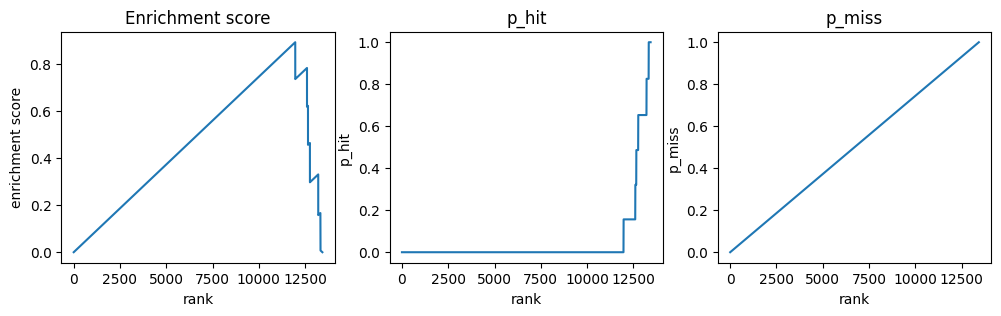

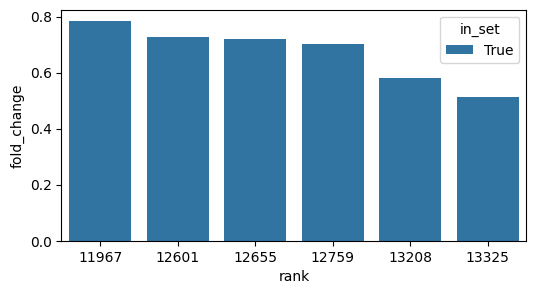

Enrichment score: 0.8913221602103943 for go term 8122 with 6 genes


In [25]:
# set up enrichment analysis

# start with one go term as example

#go_idx = go_ids_nonzero[0]
print(adata_go.obs.iloc[go_idx])
print(f"{int(adata_go.X[go_idx,:].sum())} out of {adata_go.X.shape[1]} genes are annotated with this term")

def enrichment_analysis(gene_df, go_id, ref_data):
    # 1. calculate enrichment score
    pos_ids = ref_data.X[go_id, :].indices
    gene_df['in_set'] = [gene in pos_ids for gene in gene_df['ref_idx']]

    enrichment_scores = []
    p_hits = []
    p_misses = []
    n_r = sum(gene_df[gene_df['in_set'] == True]['rank'].values)
    n_h = len(pos_ids)
    n = len(gene_df)
    epsilon = 1e-6
    for i in range(1,len(gene_df)+1):
        p_hit = (sum(gene_df.iloc[:i][gene_df['in_set'] == True]['rank'].values) + epsilon) / n_r
        p_miss = (len(gene_df.iloc[:i][gene_df['in_set'] == False]['rank'].values) + epsilon) / (n - n_h)
        p_hits.append(p_hit)
        p_misses.append(p_miss)
        enrichment_scores.append(abs(p_hit - p_miss))
    es = max(enrichment_scores)
    # plot the enrichment scores vs is
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].plot(enrichment_scores)
    ax[0].set_xlabel('rank')
    ax[0].set_ylabel('enrichment score')
    ax[0].set_title('Enrichment score')
    ax[1].plot(p_hits)
    ax[1].set_xlabel('rank')
    ax[1].set_ylabel('p_hit')
    ax[1].set_title('p_hit')
    ax[2].plot(p_misses)
    ax[2].set_xlabel('rank')
    ax[2].set_ylabel('p_miss')
    ax[2].set_title('p_miss')
    plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    plot_df = gene_df[gene_df['in_set'] == True]
    sns.barplot(plot_df, x='rank', y='fold_change', hue='in_set', ax=ax)
    #ax.set_xlim(0, len(gene_df))
    plt.show()
    return es, n_h

enrichment_score, go_list_length = enrichment_analysis(gene_p_values_ranked, go_idx, adata_go)
print(f"Enrichment score: {enrichment_score} for go term {go_idx} with {go_list_length} genes")

In [30]:
def enrichment_analysis(gene_df, go_id, ref_data):
    # 1. calculate enrichment score
    pos_ids = ref_data.X[go_id, :].indices
    gene_df['in_set'] = [gene in pos_ids for gene in gene_df['ref_idx']]

    enrichment_scores = []
    p_hits = []
    p_misses = []
    n_r = sum(gene_df[gene_df['in_set'] == True]['rank'].values)
    n_h = len(pos_ids)
    n = len(gene_df)
    epsilon = 1e-6
    for i in range(1,len(gene_df)+1):
        p_hit = (sum(gene_df.iloc[:i][gene_df['in_set'] == True]['rank'].values) + epsilon) / n_r
        p_miss = (len(gene_df.iloc[:i][gene_df['in_set'] == False]['rank'].values) + epsilon) / (n - n_h)
        p_hits.append(p_hit)
        p_misses.append(p_miss)
        enrichment_scores.append(abs(p_hit - p_miss))
    es = max(enrichment_scores)
    # plot the enrichment scores vs is
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].plot(enrichment_scores)
    ax[0].set_xlabel('rank')
    ax[0].set_ylabel('enrichment score')
    ax[0].set_title('Enrichment score')
    ax[1].plot(p_hits)
    ax[1].set_xlabel('rank')
    ax[1].set_ylabel('p_hit')
    ax[1].set_title('p_hit')
    ax[2].plot(p_misses)
    ax[2].set_xlabel('rank')
    ax[2].set_ylabel('p_miss')
    ax[2].set_title('p_miss')
    plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    plot_df = gene_df[gene_df['in_set'] == True]
    sns.barplot(plot_df, x='rank', y='fold_change', hue='in_set', ax=ax)
    #ax.set_xlim(0, len(gene_df))
    plt.show()
    return es, n_h

In [16]:
# find the go term for carbin dioxide transport

known_term = df_go_levels[df_go_levels['go_name'].str.contains('erythrocyte development')]['go_id'].values[0]
print(known_term)
go_idx = list(adata_go.obs['go_id']).index(known_term)
print(go_idx)
print(adata_go.obs.iloc[go_idx])

GO:0048821
22017
go_id                    GO:0048821
go_name     erythrocyte development
go_level                          6
Name: 22017, dtype: object


go_id                    GO:0048821
go_name     erythrocyte development
go_level                          6
Name: 22017, dtype: object
21 out of 13431 genes are annotated with this term


/tmp/ipykernel_2766958/2541659278.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_hit = (sum(gene_df.iloc[:i][gene_df['in_set'] == True]['rank'].values) + epsilon) / n_r
/tmp/ipykernel_2766958/2541659278.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_miss = (len(gene_df.iloc[:i][gene_df['in_set'] == False]['rank'].values) + epsilon) / (n - n_h)


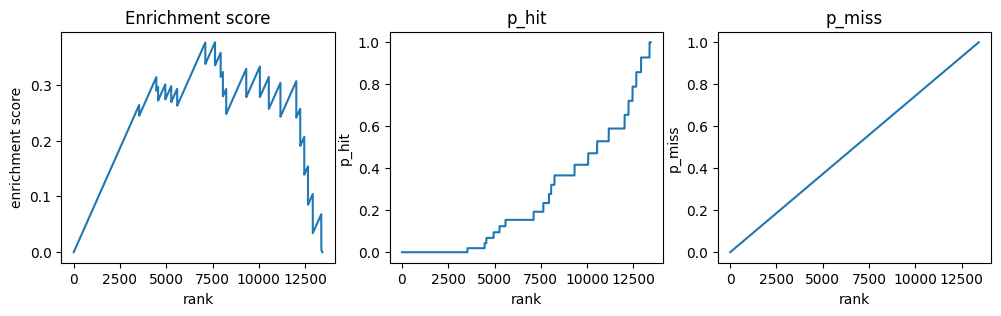

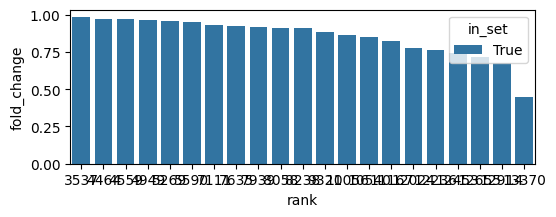

Enrichment score: 0.3760230422243279 for go term 22017 with 21 genes


In [31]:
# set up enrichment analysis

# start with one go term as example

#go_idx = go_ids_nonzero[0]
print(adata_go.obs.iloc[go_idx])
print(f"{int(adata_go.X[go_idx,:].sum())} out of {adata_go.X.shape[1]} genes are annotated with this term")

enrichment_score, go_list_length = enrichment_analysis(gene_p_values_ranked, go_idx, adata_go)
print(f"Enrichment score: {enrichment_score} for go term {go_idx} with {go_list_length} genes")

In [18]:
import tqdm

def run_enrichment(ranks, in_set, n_r, n_h, n, epsilon, i):
    p_hit = (sum((ranks[:i])[in_set[:i]]) + epsilon) / n_r
    p_miss = (len((ranks[:i])[~in_set[:i]]) + epsilon) / (n - n_h)
    return abs(p_hit - p_miss)

def enrichment_analysis(gene_df, go_id, ref_data):
    # 1. calculate enrichment score
    pos_ids = ref_data.X[go_id, :].indices
    gene_df['in_set'] = [gene in pos_ids for gene in gene_df['ref_idx']]
    
    n_r = sum(gene_df[gene_df['in_set'] == True]['rank'].values)
    n_h = len(pos_ids)
    n = len(gene_df)
    epsilon = 1e-6
    ranks = gene_df['rank'].values
    in_set = gene_df['in_set'].values
    pool = mp.Pool(mp.cpu_count())
    enrichment_scores = pool.starmap(run_enrichment, [(ranks, in_set, n_r, n_h, n, epsilon, i) for i in range(1,len(gene_df)+1)])
    es = max(enrichment_scores)
    return es

In [19]:
# set up enrichment analysis
enrichment_scores = []

for go_idx in tqdm.tqdm(range(adata_go.X.shape[0])):
    if go_idx not in go_ids_nonzero:
        enrichment_scores.append(0)
    else:
        enrichment_score = enrichment_analysis(gene_p_values_ranked, go_idx, adata_go)
        enrichment_scores.append(enrichment_score)

es_data = adata_go.obs.clone()
es_data['enrichment_score'] = enrichment_scores

print(es_data.sort_values(by='enrichment_score', ascending=False))

# save the data
es_data.to_csv('03_results/enrichment_scores_feat_2306.tsv', sep='\t', index=False)

  3%|▎         | 1307/44017 [47:38<27:19:06,  2.30s/it]Exception ignored in: <function _releaseLock at 0x7f74c1f2eb80>
Traceback (most recent call last):
  File "/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  3%|▎         | 1313/44017 [47:50<23:00:28,  1.94s/it]

### run for feat 2306

In [14]:
min_genes = 20
max_genes = 400

# get the ids that are within this range
go_ids_filtered = np.where((adata_go.X.sum(axis=1) >= min_genes) & (adata_go.X.sum(axis=1) <= max_genes))[0]
print(f"There are {len(go_ids_filtered)} go terms with at least one gene associated")

There are 1490 go terms with at least one gene associated


In [15]:
gene_p_values_ranked = gene_p_values.sort_values(by='fold_change', ascending=True)
gene_p_values_ranked['rank'] = range(1, len(gene_p_values_ranked)+1)
# now sort them by the adata_go matrix
gene_p_values_ranked['ref_idx'] = [list(adata_go.var['name']).index(gene) for gene in gene_p_values_ranked['gene']]

gene_p_values_ranked

,gene,p_value,fold_change,adj_p_value,rank,ref_idx
4751,NKAIN2,2.530977e-09,0.244833,3.237481e-07,1,4751
1615,MEIS1,4.419125e-12,0.253653,1.521879e-09,2,1615
887,PKLR,5.170622e-22,0.255141,2.314887e-18,3,887
12540,AJ009632.2,1.629672e-11,0.256410,4.210484e-09,4,12540
5880,ANGPT1,4.695543e-13,0.270632,2.102194e-10,5,5880
...,...,...,...,...,...,...
8992,AL355076.2,2.946725e-01,1.576079,6.612642e-01,13427,8992
8697,AL590807.1,6.226926e-02,1.580526,2.606688e-01,13428,8697
5691,ZMAT4,2.109889e-01,1.583691,5.621355e-01,13429,5691
9421,LINC00926,2.127745e-01,1.604363,5.650022e-01,13430,9421


In [50]:
import tqdm
import scipy.stats as stats

def run_enrichment(ranks, in_set, n_r, n_h, n, epsilon, i):
    p_hit = (sum((ranks[:i])[in_set[:i]]) + epsilon) / n_r
    p_miss = (len((ranks[:i])[~in_set[:i]]) + epsilon) / (n - n_h)
    return abs(p_hit - p_miss)

def binomial_test(n_study, n_hit, n_c, n):
    p_c = n_c / n # this is the expected probability of a hit
    results = stats.binomtest(n_hit, n_study, p_c)
    over_under = '+' if n_hit > (n_study * p_c) else '-'
    return results.pvalue, over_under

def mann_whitney_u_test(ranks, in_set):
    # s stands for set, t for total
    n_s = sum(in_set)
    n_t = len(ranks)
    r_s = sum(ranks[in_set]) / n_s
    r_t = sum(ranks) / n_t
    # according to PANTHER paper
    u_s = n_s * n_t + ((n_s * (n_s + 1)) / 2) - r_s
    u_t = n_t * n_t + ((n_s * (n_t + 1)) / 2) - r_t
    u = max(u_s, u_t)
    z_score = (u - (n_s * n_t / 2)) / math.sqrt(n_s * n_t * (n_s + n_t + 1) / 12)
    p_value = stats.norm.cdf(z_score)
    return z_score, p_value

def go_analysis(gene_df, go_id, ref_data, p_threshold=1e-5, fold_change_threshold=None):
    pos_ids = ref_data.X[go_id, :].indices
    gene_df['in_set'] = [gene in pos_ids for gene in gene_df['ref_idx']]

    ###
    # binomial test
    ###
    gene_df_selected = gene_df[(gene_df['adj_p_value'] < p_threshold)]
    if fold_change_threshold is not None:
        gene_df_selected = gene_df_selected[(gene_df_selected['fold_change'] > fold_change_threshold) | (gene_df_selected['fold_change'] < 1/fold_change_threshold)]
    n_hits = sum(gene_df_selected['in_set'])
    binom_pval, binom_direction = binomial_test(
        len(gene_df_selected),
        sum(gene_df_selected['in_set']),
        len(pos_ids),
        len(gene_df)
    )
    #print(f"Binomial test: {len(gene_df_selected)} {n_hits} {binom_pval} {binom_direction}")
    
    ###
    # Mann-Whitney U test
    ###
    z_score, mw_pval = mann_whitney_u_test(
        gene_df['rank'].values, 
        gene_df['in_set'].values
    )
    #print(f"Mann-Whitney U test: {z_score} {mw_pval}")

    ###
    # calculate enrichment score
    ###
    
    n_r = sum(gene_df[gene_df['in_set'] == True]['rank'].values)
    n_h = len(pos_ids)
    n = len(gene_df)
    epsilon = 1e-6
    ranks = gene_df['rank'].values
    in_set = gene_df['in_set'].values
    steps = range(1,len(gene_df)+1,100)
    pool = mp.Pool(mp.cpu_count())
    enrichment_scores = pool.starmap(run_enrichment, [(ranks, in_set, n_r, n_h, n, epsilon, i) for i in steps])
    es = max(enrichment_scores)
    #print(f"Enrichment score: {es}")
    return n_hits, binom_pval, binom_direction, z_score, mw_pval, es

In [16]:
adata_go_filtered = adata_go[go_ids_filtered, :]
adata_go_filtered

View of AnnData object with n_obs × n_vars = 1490 × 13431
    obs: 'go_id', 'go_name', 'go_level'
    var: 'Ensembl', 'UniProtKB-AC', 'name'

In [19]:
# find the go term for carbin dioxide transport

known_term = df_go_levels[df_go_levels['go_name'].str.contains('erythrocyte development')]['go_id'].values[0]
print(known_term)
go_idx = list(adata_go_filtered.obs['go_id']).index(known_term)
print(go_idx)
print(adata_go_filtered.obs.iloc[go_idx])

GO:0048821
1156
go_id                    GO:0048821
go_name     erythrocyte development
go_level                          6
Name: 22017, dtype: object


In [38]:
# show me the genes for this go term
pos_ids = adata_go_filtered.X[go_idx, :].indices
print(adata_go_filtered.var.iloc[pos_ids]['name'].values)
print(top_genes.values)
# check if there is any overlap with top_genes
print(set(adata_go_filtered.var.iloc[pos_ids]['name'].values) & set(top_genes.values))

['ABCB10' 'ALAS1' 'BCL6' 'LYAR' 'SRF' 'RHAG' 'CITED2' 'SLC25A40' 'BPGM'
 'DMTN' 'RPS6' 'SLC11A2' 'NCKAP1L' 'SH2B3' 'ARID4A' 'TMOD3' 'MED1'
 'SLC4A1' 'JMJD6' 'GATA1' 'ALAS2']
['TMEM14C' 'TK1' 'PKLR' 'TEDC2' 'NME4' 'GAS2L1' 'FEN1' 'CDT1' 'PAQR4'
 'LINC01133' 'CHRM3' 'SPINK2' 'TYMS' 'PCLAF' 'KCNH2' 'CD34' 'MCM2' 'TST'
 'BEX3' 'GINS2' 'PRG2' 'ANGPT1' 'PRKG1' 'MCM4' 'ST6GALNAC1' 'MEIS1'
 'PRSS57' 'AJ009632.2' 'MECOM' 'MIR99AHG' 'ADGRG6' 'DMC1' 'TUBG1' 'HEBP1'
 'C1QTNF4' 'GUCY1A1' 'NKAIN2' 'EGFL7' 'SLC29A1' 'PRDX2' 'LINC01122' 'E2F1'
 'RECQL4' 'CDCA5' 'PKMYT1' 'HMGB3' 'SMIM1' 'ZWINT' 'CDC6' 'BAALC' 'CCNE1'
 'CASC15' 'HES6' 'CAVIN2' 'PRKG2' 'MYL4']
set()


In [ ]:
enrichment_score = go_analysis(gene_p_values_ranked, go_idx, adata_go_filtered, p_threshold=1e-5, fold_change_threshold=2.0)

Binomial test: 221 0 1.0 -
Mann-Whitney U test: 10144.199563963875 1.0
Enrichment score: 0.26323639068880345


In [52]:
# set up enrichment analysis
results = {'n_hits': [], 'binom_pval': [], 'binom_direction': [], 'z_score': [], 'mw_pval': [], 'es': []}

for go_idx in tqdm.tqdm(range(adata_go_filtered.X.shape[0])):
    # print the go term and name and enrichment score
    results_temp = go_analysis(gene_p_values_ranked, go_idx, adata_go_filtered, p_threshold=1e-5, fold_change_threshold=2.0)
    for i, key in enumerate(results.keys()):
        results[key].append(results_temp[i])

# make the results a dataframe
results_df = pd.DataFrame(results)
results_df['go_id'] = adata_go_filtered.obs['go_id'].values
results_df['go_name'] = adata_go_filtered.obs['go_name'].values
results_df['go_level'] = adata_go_filtered.obs['go_level'].values

# save the data
results_df.to_csv('03_results/reports/enrichment_scores_feat_2306.tsv', sep='\t', index=False)

100%|██████████| 1490/1490 [1:28:06<00:00,  3.55s/it]


In [54]:
results_df[results_df['binom_pval'] < 0.05]

,n_hits,binom_pval,binom_direction,z_score,mw_pval,es,go_id,go_name,go_level
2,2,0.009013,+,7968.530787,1.0,0.120867,GO:0000070,mitotic sister chromatid segregation,4
4,2,0.004991,+,9295.930693,1.0,0.213503,GO:0000079,regulation of cyclin-dependent protein serine/...,6
23,4,0.000924,+,4566.562008,1.0,0.196675,GO:0000278,mitotic cell cycle,3
38,2,0.020827,+,6377.840165,1.0,0.175057,GO:0000723,telomere maintenance,6
42,5,0.000354,+,3842.830615,1.0,0.211890,GO:0000781,"chromosome, telomeric region",3
47,2,0.009526,+,7853.578109,1.0,0.339134,GO:0000794,condensed nuclear chromosome,7
64,3,0.021613,+,3883.640790,1.0,0.304199,GO:0001525,angiogenesis,3
77,2,0.020101,+,6439.112256,1.0,0.305154,GO:0001669,acrosomal vesicle,9
127,3,0.022009,+,3869.895269,1.0,0.241212,GO:0003689,DNA clamp loader activity,3
128,3,0.006401,+,4887.596728,1.0,0.295847,GO:0003690,double-stranded DNA binding,5


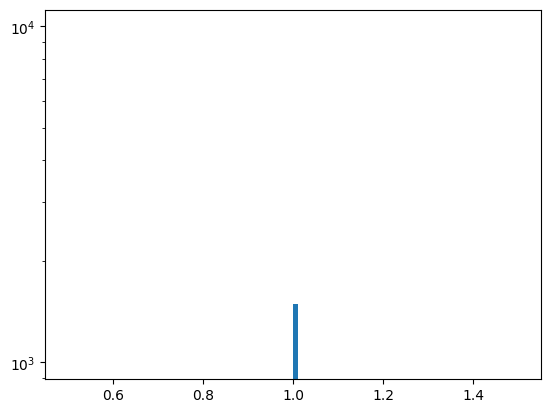

In [58]:
plt.hist(results_df['mw_pval'].values, bins=100)
plt.yscale('log')
plt.show()

In [59]:
import tqdm
import scipy.stats as stats

def run_enrichment(ranks, in_set, n_r, n_h, n, epsilon, i):
    p_hit = (sum((ranks[:i])[in_set[:i]]) + epsilon) / n_r
    p_miss = (len((ranks[:i])[~in_set[:i]]) + epsilon) / (n - n_h)
    return abs(p_hit - p_miss)

def binomial_test(n_study, n_hit, n_c, n):
    p_c = n_c / n # this is the expected probability of a hit
    results = stats.binomtest(n_hit, n_study, p_c)
    over_under = '+' if n_hit > (n_study * p_c) else '-'
    return results.pvalue, over_under

def mann_whitney_u_test(ranks, in_set):
    # s stands for set, t for total
    n_s = sum(in_set)
    #n_t = len(ranks)
    #r_s = sum(ranks[in_set]) / n_s
    #r_t = sum(ranks) / n_t
    # according to PANTHER paper
    """
    u_s = n_s * n_t + ((n_s * (n_s + 1)) / 2) - r_s
    u_t = n_t * n_t + ((n_s * (n_t + 1)) / 2) - r_t
    u = max(u_s, u_t)
    z_score = (u - (n_s * n_t / 2)) / math.sqrt(n_s * n_t * (n_s + n_t + 1) / 12)
    p_value = stats.norm.cdf(z_score)
    """
    # according to wikipedia
    n_t = len(ranks[~in_set])
    r_s = sum(ranks[in_set])
    r_t = sum(ranks[~in_set])
    u_s = n_s * n_t + ((n_s * (n_s + 1)) / 2) - r_s
    u_t = n_s * n_t + ((n_t * (n_t + 1)) / 2) - r_t
    u = min(u_s, u_t)
    z_score = (u - (n_s * n_t / 2)) / math.sqrt(n_s * n_t * (n_s + n_t + 1) / 12)
    p_value = stats.norm.cdf(z_score)
    effect_size = u_s / (n_s * n_t)
    return z_score, p_value, effect_size

def go_analysis(gene_df, go_id, ref_data, p_threshold=1e-5, fold_change_threshold=None):
    pos_ids = ref_data.X[go_id, :].indices
    gene_df['in_set'] = [gene in pos_ids for gene in gene_df['ref_idx']]

    ###
    # binomial test
    ###
    gene_df_selected = gene_df[(gene_df['adj_p_value'] < p_threshold)]
    if fold_change_threshold is not None:
        gene_df_selected = gene_df_selected[(gene_df_selected['fold_change'] > fold_change_threshold) | (gene_df_selected['fold_change'] < 1/fold_change_threshold)]
    n_hits = sum(gene_df_selected['in_set'])
    binom_pval, binom_direction = binomial_test(
        len(gene_df_selected),
        sum(gene_df_selected['in_set']),
        len(pos_ids),
        len(gene_df)
    )
    #print(f"Binomial test: {len(gene_df_selected)} {n_hits} {binom_pval} {binom_direction}")
    
    ###
    # Mann-Whitney U test
    ###
    z_score, mw_pval, effect_size = mann_whitney_u_test(
        gene_df['rank'].values, 
        gene_df['in_set'].values
    )
    #print(f"Mann-Whitney U test: {z_score} {mw_pval}")

    ###
    # calculate enrichment score
    ###
    
    n_r = sum(gene_df[gene_df['in_set'] == True]['rank'].values)
    n_h = len(pos_ids)
    n = len(gene_df)
    epsilon = 1e-6
    ranks = gene_df['rank'].values
    in_set = gene_df['in_set'].values
    steps = range(1,len(gene_df)+1,100)
    pool = mp.Pool(mp.cpu_count())
    enrichment_scores = pool.starmap(run_enrichment, [(ranks, in_set, n_r, n_h, n, epsilon, i) for i in steps])
    es = max(enrichment_scores)
    #print(f"Enrichment score: {es}")
    return n_hits, binom_pval, binom_direction, z_score, mw_pval, effect_size, es

In [60]:
# set up enrichment analysis
results = {'n_hits': [], 'binom_pval': [], 'binom_direction': [], 'z_score': [], 'mw_pval': [], 'effect_size': [], 'es': []}

for go_idx in tqdm.tqdm(range(adata_go_filtered.X.shape[0])):
    # print the go term and name and enrichment score
    results_temp = go_analysis(gene_p_values_ranked, go_idx, adata_go_filtered, p_threshold=1e-5, fold_change_threshold=2.0)
    for i, key in enumerate(results.keys()):
        results[key].append(results_temp[i])

# make the results a dataframe
results_df = pd.DataFrame(results)
results_df['go_id'] = adata_go_filtered.obs['go_id'].values
results_df['go_name'] = adata_go_filtered.obs['go_name'].values
results_df['go_level'] = adata_go_filtered.obs['go_level'].values

# save the data
results_df.to_csv('03_results/reports/enrichment_scores_feat_2306_2.tsv', sep='\t', index=False)

100%|██████████| 1490/1490 [1:31:11<00:00,  3.67s/it]


In [3]:
# load the dataframe

results_df = pd.read_csv('03_results/reports/enrichment_scores_feat_2306_2.tsv', sep='\t')

In [4]:
results_df[results_df['binom_pval'] < 0.05]

,n_hits,binom_pval,binom_direction,z_score,mw_pval,effect_size,es,go_id,go_name,go_level
2,2,0.009013,+,-5.725877,5.145052e-09,0.783843,0.120867,GO:0000070,mitotic sister chromatid segregation,4
4,2,0.004991,+,-2.346317,9.479975e-03,0.635596,0.213503,GO:0000079,regulation of cyclin-dependent protein serine/...,6
23,4,0.000924,+,-5.760656,4.189375e-09,0.664494,0.196675,GO:0000278,mitotic cell cycle,3
38,2,0.020827,+,-2.673817,3.749670e-03,0.606238,0.175057,GO:0000723,telomere maintenance,6
42,5,0.000354,+,-4.795329,8.120399e-07,0.615589,0.211890,GO:0000781,"chromosome, telomeric region",3
47,2,0.009526,+,-4.306347,8.298645e-06,0.710410,0.339134,GO:0000794,condensed nuclear chromosome,7
64,3,0.021613,+,-0.277356,3.907533e-01,0.493245,0.304199,GO:0001525,angiogenesis,3
77,2,0.020101,+,-1.185886,1.178337e-01,0.547567,0.305154,GO:0001669,acrosomal vesicle,9
127,3,0.022009,+,-2.444515,7.252344e-03,0.559330,0.241212,GO:0003689,DNA clamp loader activity,3
128,3,0.006401,+,-2.996626,1.364926e-03,0.591495,0.295847,GO:0003690,double-stranded DNA binding,5


In [6]:
results_df[(results_df['binom_pval'] < 0.05) & (results_df['mw_pval'] < 0.05)]

,n_hits,binom_pval,binom_direction,z_score,mw_pval,effect_size,es,go_id,go_name,go_level
2,2,0.009013,+,-5.725877,5.145052e-09,0.783843,0.120867,GO:0000070,mitotic sister chromatid segregation,4
4,2,0.004991,+,-2.346317,9.479975e-03,0.635596,0.213503,GO:0000079,regulation of cyclin-dependent protein serine/...,6
23,4,0.000924,+,-5.760656,4.189375e-09,0.664494,0.196675,GO:0000278,mitotic cell cycle,3
38,2,0.020827,+,-2.673817,3.749670e-03,0.606238,0.175057,GO:0000723,telomere maintenance,6
42,5,0.000354,+,-4.795329,8.120399e-07,0.615589,0.211890,GO:0000781,"chromosome, telomeric region",3
47,2,0.009526,+,-4.306347,8.298645e-06,0.710410,0.339134,GO:0000794,condensed nuclear chromosome,7
127,3,0.022009,+,-2.444515,7.252344e-03,0.559330,0.241212,GO:0003689,DNA clamp loader activity,3
128,3,0.006401,+,-2.996626,1.364926e-03,0.591495,0.295847,GO:0003690,double-stranded DNA binding,5
129,3,0.009238,+,-5.110878,1.603325e-07,0.645940,0.163885,GO:0003697,single-stranded DNA binding,5
156,3,0.030764,+,-3.511129,2.231036e-04,0.420121,0.367667,GO:0004672,protein kinase activity,3


In [20]:
import tqdm
import scipy.stats as stats

def run_enrichment(ranks, in_set, n_r, n_h, n, epsilon, i):
    p_hit = (sum((ranks[:i])[in_set[:i]]) + epsilon) / n_r
    p_miss = (len((ranks[:i])[~in_set[:i]]) + epsilon) / (n - n_h)
    return abs(p_hit - p_miss)

def binomial_test(n_study, n_hit, n_c, n):
    p_c = n_c / n # this is the expected probability of a hit
    results = stats.binomtest(n_hit, n_study, p_c)
    over_under = '+' if n_hit > (n_study * p_c) else '-'
    fold_enrichment = n_hit / (n_study * p_c)
    fdr = (n_study - n_hit) / n_study
    expected = n_study * p_c
    return results.pvalue, expected, over_under, fold_enrichment, fdr

def mann_whitney_u_test(ranks, in_set):
    # s stands for set, t for total
    n_s = sum(in_set)
    #n_t = len(ranks)
    #r_s = sum(ranks[in_set]) / n_s
    #r_t = sum(ranks) / n_t
    # according to PANTHER paper
    """
    u_s = n_s * n_t + ((n_s * (n_s + 1)) / 2) - r_s
    u_t = n_t * n_t + ((n_s * (n_t + 1)) / 2) - r_t
    u = max(u_s, u_t)
    z_score = (u - (n_s * n_t / 2)) / math.sqrt(n_s * n_t * (n_s + n_t + 1) / 12)
    p_value = stats.norm.cdf(z_score)
    """
    # according to wikipedia
    n_t = len(ranks[~in_set])
    r_s = sum(ranks[in_set])
    r_t = sum(ranks[~in_set])
    u_s = n_s * n_t + ((n_s * (n_s + 1)) / 2) - r_s
    u_t = n_s * n_t + ((n_t * (n_t + 1)) / 2) - r_t
    u = min(u_s, u_t)
    z_score = (u - (n_s * n_t / 2)) / math.sqrt(n_s * n_t * (n_s + n_t + 1) / 12)
    p_value = stats.norm.cdf(z_score)
    effect_size = u_s / (n_s * n_t)
    return z_score, p_value, effect_size

def go_analysis(gene_df, go_id, ref_data, p_threshold=1e-5, fold_change_threshold=None):
    pos_ids = ref_data.X[go_id, :].indices
    gene_df['in_set'] = [gene in pos_ids for gene in gene_df['ref_idx']]

    gene_df_selected = gene_df[(gene_df['adj_p_value'] < p_threshold)]
    if fold_change_threshold is not None:
        gene_df_selected = gene_df_selected[(gene_df_selected['fold_change'] > fold_change_threshold) | (gene_df_selected['fold_change'] < 1/fold_change_threshold)]
    
    ###
    # binomial test
    ###
    hit_positions = gene_df_selected['ref_idx'].values
    n_hits = sum(gene_df_selected['in_set'])
    binom_pval, binom_expected, binom_direction, binom_fold, binom_fdr = binomial_test(
        len(gene_df_selected),
        sum(gene_df_selected['in_set']),
        len(pos_ids),
        len(gene_df)
    )
    #print(f"Binomial test: {len(gene_df_selected)} {n_hits} {binom_pval} {binom_direction}")
    
    ###
    # Mann-Whitney U test
    ###
    z_score, mw_pval, effect_size = mann_whitney_u_test(
        gene_df['rank'].values, 
        gene_df['in_set'].values
    )
    #print(f"Mann-Whitney U test: {z_score} {mw_pval}")

    ###
    # calculate enrichment score
    ###
    """
    n_r = sum(gene_df[gene_df['in_set'] == True]['rank'].values)
    n_h = len(pos_ids)
    n = len(gene_df)
    epsilon = 1e-6
    ranks = gene_df['rank'].values
    in_set = gene_df['in_set'].values
    steps = range(1,len(gene_df)+1,100)
    pool = mp.Pool(mp.cpu_count())
    enrichment_scores = pool.starmap(run_enrichment, [(ranks, in_set, n_r, n_h, n, epsilon, i) for i in steps])
    es = max(enrichment_scores)
    """
    #print(f"Enrichment score: {es}")
    return n_hits, binom_expected, binom_pval, binom_direction, binom_fold, binom_fdr, z_score, mw_pval, effect_size, hit_positions

In [18]:
gene_hits_per_feature = np.zeros((len(active_feature_ids), adata_go_filtered.X.shape[1]))

In [21]:
# set up enrichment analysis
results = {'n_hits': [], 'expected': [], 'binom_pval': [], 'binom_direction': [], 'binom_fold_change': [], 'fdr': [], 'z_score': [], 'mw_pval': [], 'effect_size': []}

p_value_threshold = 1e-5
fold_change_threshold = 2.0

for go_idx in tqdm.tqdm(range(adata_go_filtered.X.shape[0])):
    # print the go term and name and enrichment score
    results_temp = go_analysis(gene_p_values_ranked, go_idx, adata_go_filtered, p_value_threshold, fold_change_threshold)
    for i, key in enumerate(results.keys()):
        results[key].append(results_temp[i])
feat_pos = np.where(active_feature_ids == feat)[0][0]
gene_hits_per_feature[feat_pos,results_temp[-1]] = 1

# make the results a dataframe
results_df = pd.DataFrame(results)
results_df['go_id'] = adata_go_filtered.obs['go_id'].values
results_df['go_name'] = adata_go_filtered.obs['go_name'].values
results_df['go_level'] = adata_go_filtered.obs['go_level'].values
results_df = results_df[(results_df['binom_pval'] < 0.05) & (results_df['mw_pval'] < 0.05)].sort_values(by='binom_fold_change', ascending=False)
results_df['feature'] = feat
# save the data
#results_df.to_csv('03_results/reports/enrichment_scores_feat_2306_3.tsv', sep='\t', index=False)

100%|██████████| 1490/1490 [01:05<00:00, 22.62it/s]


In [23]:
results_df = results_df[(results_df['binom_pval'] < 0.05) & (results_df['mw_pval'] < 0.05)].sort_values(by='binom_fold_change', ascending=False)

In [24]:
results_df

,n_hits,expected,binom_pval,binom_direction,binom_fold_change,fdr,z_score,mw_pval,effect_size,go_id,go_name,go_level,feature
292,4,0.091728,0.000002,+,43.607143,0.928571,-6.231813,2.305332e-10,0.883870,GO:0006268,DNA unwinding involved in DNA replication,9,2306
293,3,0.108406,0.000186,+,27.673764,0.946429,-5.057594,2.122898e-07,0.786618,GO:0006270,DNA replication initiation,6,2306
4,2,0.104236,0.004991,+,19.187143,0.964286,-2.346317,9.479975e-03,0.635596,GO:0000079,regulation of cyclin-dependent protein serine/...,6,2306
289,2,0.112575,0.005791,+,17.765873,0.964286,-1.848265,3.228204e-02,0.602789,GO:0006139,nucleobase-containing compound metabolic process,4,2306
1268,3,0.187626,0.000913,+,15.989286,0.946429,-2.331939,9.851961e-03,0.600523,GO:0061749,forked DNA-dependent helicase activity,4,2306
915,3,0.191795,0.000972,+,15.641693,0.946429,-2.323413,1.007849e-02,0.599064,GO:0036121,double-stranded DNA helicase activity,4,2306
513,3,0.191795,0.000972,+,15.641693,0.946429,-2.236183,1.266991e-02,0.595345,GO:0009378,four-way junction helicase activity,4,2306
1135,2,0.133423,0.008026,+,14.989955,0.964286,-3.128303,8.790935e-04,0.659837,GO:0048146,positive regulation of fibroblast proliferation,6,2306
290,5,0.333557,0.000022,+,14.989955,0.910714,-7.564203,1.951256e-14,0.744873,GO:0006260,DNA replication,6,2306
2,2,0.141762,0.009013,+,14.108193,0.964286,-5.725877,5.145052e-09,0.783843,GO:0000070,mitotic sister chromatid segregation,4,2306


In [ ]:
results_df[(results_df['binom_pval'] < 0.05) & (results_df['mw_pval'] < 0.05)].sort_values(by='binom_fold_change', ascending=False)

# Look at chromatin accessibility

In [2]:
# load model and data

dev_id = 3
device = torch.device(f"cuda:{dev_id}" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {device}")
    data_dir = '/home/vschuste/data/singlecell/'
else:
    data_dir = '/Users/vschuste/Documents/work/data/singlecell/'

data = ad.read_h5ad(data_dir+'human_bonemarrow.h5ad')

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e').to(device)
data = data[data.obs["train_val_test"] == "train"]
library = data.obs['ATAC_nCount_peaks'].values
data_peak_names = (data.var[data.var['modality'] == 'ATAC']).index
del data
gc.collect()
# get the model's dispersions for the DEG test
with torch.no_grad():
    dispersion_factors = (torch.exp(model.decoder.out_modules[1].distribution.log_r).detach().cpu().numpy() + 1).flatten()

reps = model.representation.z.detach()

Using GPU: cuda:3
Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        


/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/multiDGD/_dgd.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self._sa

#######################
Training status
#######################
True


In [8]:
# load the SAE model and activations

sae_model_save_name = '03_results/models/sae_model_10000_l1-1e-3_lr-1e-4_500epochs'

input_size = reps.shape[1]
hidden_size = 10**4
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt'))
sae_model.to(device)

activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

/tmp/ipykernel_4059395/212179595.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt'))
/tmp/ipykernel_4059395/

In [9]:
feat = 2306
print("Investigating feature ", feat)

# get the sample IDs of the top 5% of the values of the feature
percentile = 99
top5pct = np.percentile(activations[feat].numpy(), percentile)
top5pct_indices = torch.where(activations[feat] > top5pct)[0]
print(f"There are {len(top5pct_indices)} samples in the top {percentile}% of the feature")

# get the reps
reps_top5pct = reps[top5pct_indices, :].clone()
cov_reps_top5pct = model.correction_rep.z[top5pct_indices, :].clone()

# get the positive predictions
y_pos = model.decoder(torch.cat((reps_top5pct, cov_reps_top5pct), dim=1))[1].detach().cpu().numpy()
y_pos = y_pos * library[top5pct_indices].reshape(-1, 1)

bottom_indices = torch.where(activations[feat] == 0.0)[0]
print(f"There are {len(bottom_indices)} samples in the bottom of the feature (value 0)")
reps_bottom = reps[bottom_indices, :].clone()
cov_reps_bottom = model.correction_rep.z[bottom_indices, :].clone()

# now get the model predictions
y_neg = model.decoder(torch.cat((reps_bottom, cov_reps_bottom), dim=1))[1].detach().cpu().numpy()
y_neg = y_neg * library[bottom_indices].reshape(-1, 1)

Investigating feature  2306
There are 100 samples in the top 99% of the feature
There are 9823 samples in the bottom of the feature (value 0)


In [18]:
# binary version
pos_chromatin_avg, pos_chromatin_se = np.mean(y_pos, axis=0), np.std(y_pos, axis=0) / math.sqrt(y_pos.shape[0])
neg_chromatin_avg, neg_chromatin_se = np.mean(y_neg, axis=0), np.std(y_neg, axis=0) / math.sqrt(y_neg.shape[0])
mean_diffs = np.abs(pos_chromatin_avg - neg_chromatin_avg)
total_ses = pos_chromatin_se + neg_chromatin_se
#significances = mean_diffs - 1.96*total_ses
conf_95 = np.where((mean_diffs - 1.96*total_ses) > 0)[0]

In [27]:
len(conf_95)

357

In [49]:
peak_diff_df = pd.DataFrame({
    'chromosome': [x.split('-')[0] for x in data_peak_names],
    'significant': (mean_diffs - 1.96*total_ses) > 0
})
peak_diff_df

,chromosome,significant
0,chr1,False
1,chr1,False
2,chr1,False
3,chr1,False
4,chr1,False
...,...,...
116485,GL000219.1,False
116486,GL000219.1,False
116487,KI270726.1,False
116488,KI270713.1,False


In [50]:
# summary statistic
chr_counts = peak_diff_df['chromosome'].value_counts()
peak_diff_df = peak_diff_df.groupby('chromosome').sum()
peak_diff_df['count'] = chr_counts
# calculate the number of expected peaks per chromosome

def binomial_test(n_study, n_hit, n_c, n):
    p_c = n_c / n # this is the expected probability of a hit
    results = stats.binomtest(n_hit, n_study, p_c)
    over_under = '+' if n_hit > (n_study * p_c) else '-'
    fold_enrichment = n_hit / (n_study * p_c)
    fdr = (n_study - n_hit) / n_study
    expected = n_study * p_c
    return results.pvalue, expected, over_under, fold_enrichment, fdr

peak_diff_df['binom_pval'], peak_diff_df['expected'], peak_diff_df['over_under'], peak_diff_df['fold_enrichment'], peak_diff_df['fdr'] = zip(*peak_diff_df.apply(lambda x: binomial_test(len(conf_95), x['significant'], x['count'], len(data_peak_names)), axis=1))
peak_diff_df

,significant,count,binom_pval,expected,over_under,fold_enrichment,fdr
chromosome,,,,,,,
GL000195.1,0,4,1.000000,0.012259,-,0.000000,1.000000
GL000205.2,0,9,1.000000,0.027582,-,0.000000,1.000000
GL000219.1,0,6,1.000000,0.018388,-,0.000000,1.000000
KI270713.1,0,2,1.000000,0.006129,-,0.000000,1.000000
KI270726.1,0,1,1.000000,0.003065,-,0.000000,1.000000
chr1,37,11497,0.722764,35.234175,+,1.050117,0.896359
chr10,17,5449,0.900051,16.699227,+,1.018011,0.952381
chr11,17,5833,1.000000,17.876049,-,0.950993,0.952381
chr12,18,5937,1.000000,18.194772,-,0.989295,0.949580


[]

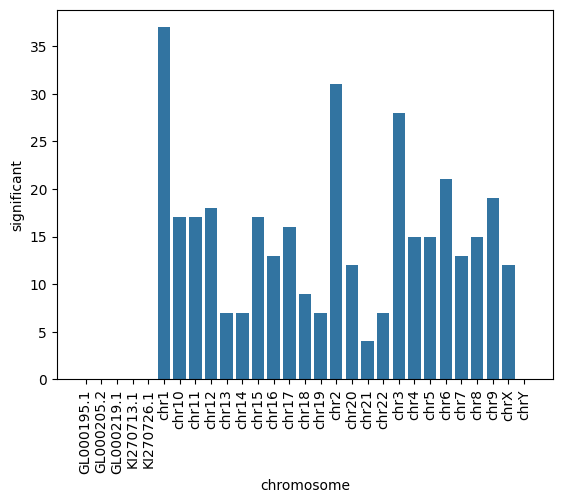

In [33]:
sns.barplot(data=peak_diff_df.groupby('chromosome').sum().reset_index(), x='chromosome', y='significant')
plt.xticks(rotation=90)
plt.plot()